The code can be used to reproduce the figures of our report.

In [ ]:
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def draw_plot(prey_history, predator_history, correlation, lag):
    plt.figure(figsize=(12,5))
    plt.grid()
    plt.title(f"Predator-prey interaction")
    plt.plot(prey_history, 'g', label = 'Prey', alpha = 0.7)
    plt.plot(predator_history, 'r', label = "Predators", alpha=0.7)
    plt.xlabel('Time t')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

# Calc Metric Functions

In [ ]:
from scipy.signal import find_peaks

def avg_max_peak(history):   # maybe do based on prominence also, like more then 10
    thres = np.mean(history)
    peaks_x, metrics = find_peaks(history, height=thres, prominence=10)
    #print(metrics)
    # print('max peak')
    # print(np.mean(metrics['peak_heights']))
    return np.mean(metrics['peak_heights']), peaks_x

def avg_max_peak_print(history):   # maybe do based on prominence also, like more then 10
    thres = np.mean(history)
    peaks_x, metrics = find_peaks(history, height=thres, prominence=10)
    #print(metrics)
    print(history)
    print(np.argmax(history))
    # print('max peak')
    # print(np.mean(metrics['peak_heights']))
    return np.mean(metrics['peak_heights']), peaks_x


def avg_min_valley(history):
    history = np.array(history) * (-1)
    thres = np.mean(history)
    valleys_x, metrics = find_peaks(history, height=thres, prominence=10)
    # print('min valley')
    # print(np.mean(metrics['peak_heights']) * (-1))
    return np.mean(metrics['peak_heights']) * (-1)


def avg_peak_width(history, n_peaks):
    return len(history) / n_peaks


# def avg_peak_height(history, n_peaks):
#     return len(history) / n_peaks


def calculate_stats(prey, predator):
    prey_peaks_mean, prey_peaks = avg_max_peak(prey)
    if len(prey_peaks) == 0:
        prey_width = 0
    else:
        prey_width = len(prey) / len(prey_peaks)


    predator_peaks_mean, predator_peaks = avg_max_peak(predator)
    if len(predator_peaks) == 0:
        predator_width = 0
    else:
        predator_width = len(predator) / len(predator_peaks)
    return {'prey_peak': prey_peaks_mean,
            'prey_valley': avg_min_valley(prey),
            'prey_width': prey_width,
            'prey_avg': np.mean(prey),


            'predator_peak': predator_peaks_mean,
            'predator_valley': avg_min_valley(predator),
            'predator_width': predator_width,
            'predator_avg': np.mean(predator)
            }


def calc_metric(prey, predator, stats, upper_value):
    stats = calculate_stats(prey, predator)
    #if stats['predator_width'] == 0 or stats['prey_width'] == 0 or (prey[-1] == 0 and predator[-1] != 0):
    if (prey[-1] == 0 and predator[-1] != 0):
        metric = upper_value
    else:
        metric = stats['prey_avg'] - stats['predator_avg']
    return metric



def get_stats(json_data, upper_value = 625):
    all_stats = {
        'metric': [],

        'prey_avg': [],
        'prey_peak': [],
        'prey_valley': [],
        'prey_width': [],
        'predator_avg': [],
        'predator_peak': [],
        'predator_valley': [],
        'predator_width': []
    }


    for item in json_data:
        stats = calculate_stats(json_data[item]['prey_history'], json_data[item]['predator_history'])
        metric = calc_metric(json_data[item]['prey_history'], json_data[item]['predator_history'], stats, upper_value)
        if metric != upper_value:
            for key in stats:
                all_stats[key].append(stats[key])
        all_stats['metric'].append(metric)

    return all_stats

def get_overall_population(json_data, upper_value = 625):
    count = 0
    for item in json_data:
        overall_pop = json_data[item]['prey_history'] + json_data[item]['predator_history']
        count = len([x for x in overall_pop if x > 600])
        if count > 0:
            print(count)
            print(json_data[item]['prey_death_rate'])
            print(json_data[item]['predator_birth_rate'])
            print(json_data[item]['prey_history'])

In [ ]:
# Create a DataFrame
black_list = ['metric', 'prey_death_rate', 'predator_birth_rate']

def plot_corr_matrix(all_stats):
    df = pd.DataFrame({col: all_stats[col] for col in all_stats.keys() if col not in black_list})

    df['peak_dif'] = df['prey_peak'] - df['predator_peak']


    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Explore Data

In [ ]:
def get_matrices(filepath):
    with open(filepath, 'r') as file:
        data = file.read()
    # matrix_prey = {0.0: {0.1}}
    matrix_prey = {}
    matrix_pred = {}
    json_data = json.loads(data)   # 21x21
    cnt = 0
    row_prey = []
    row_pred = []
    for item in json_data:
        cnt += 1
        if json_data[item]['prey_death_rate'] not in matrix_prey:
            matrix_prey[json_data[item]['prey_death_rate']] = {}
            matrix_pred[json_data[item]['prey_death_rate']] = {}

        matrix_prey[json_data[item]['prey_death_rate']][json_data[item]['predator_birth_rate']] = json_data[item]['prey_history']
        matrix_pred[json_data[item]['prey_death_rate']][json_data[item]['predator_birth_rate']] = json_data[item]['predator_history']
    return matrix_prey, matrix_pred



def plot_from_params(filepath, prey_death_rate, pred_birth_rate, upper_value=625, phase_plot=False):
    matrix_prey, matrix_pred = get_matrices(filepath)

    history_prey = matrix_prey[prey_death_rate][pred_birth_rate]
    history_pred = matrix_pred[prey_death_rate][pred_birth_rate]

    if phase_plot:
        draw_phase_plot(history_prey, history_pred)
    else:
        print(history_prey)
        print(history_pred)
        stats = calculate_stats(history_prey, history_pred)
        metric = calc_metric(history_prey, history_pred, stats, upper_value)
        print(f'Metric: {metric}')
        print(f'prey_death_rate: {prey_death_rate}')
        print(f'predator_birth_rate: {pred_birth_rate}')
        draw_plot(history_prey, history_pred, 0, 0)



def draw_phase_plot(prey_population, predator_population):
    # Create the phase plot
    plt.figure(figsize=(8, 6))
    plt.plot(prey_population, predator_population, marker='o')

    # Label the axes
    plt.xlabel('Prey Population')
    plt.ylabel('Predator Population')
    plt.title('Phase Plot of Prey vs Predator Population')

    # Optionally, add arrows to indicate the direction of time
    for i in range(1, len(prey_population)):
        plt.arrow(prey_population[i-1], predator_population[i-1],
                  prey_population[i] - prey_population[i-1],
                  predator_population[i] - predator_population[i-1],
                  head_width=0.5, head_length=0.5, fc='blue', ec='blue')

    # Show the plot
    plt.grid(True)
    plt.show()


def phase_plots_from_file_pathes(pathes, prey_death_rate, pred_birth_rate, names):
    histories = []
    for path in pathes:
        matrix_prey, matrix_pred = get_matrices(path)

        history_prey = matrix_prey[prey_death_rate][pred_birth_rate]
        history_pred = matrix_pred[prey_death_rate][pred_birth_rate]
        histories.append((history_prey, history_pred))
    plot_multiple_phase_plots(histories, names)


def plot_multiple_phase_plots(population_histories, names):
    """
    Plots multiple phase plots on the same figure.

    Args:
        population_histories (list of tuples): A list of N tuples, each containing two lists.
                                               The first list in each tuple represents the prey population history,
                                               and the second list represents the predator population history.
    """
    plt.figure(figsize=(10, 8))

    for i, (prey_population, predator_population) in enumerate(population_histories):
        plt.plot(prey_population, predator_population, marker='o', label=names[i])
        for j in range(1, len(prey_population)):
            plt.arrow(prey_population[j-1], predator_population[j-1],
                      prey_population[j] - prey_population[j-1],
                      predator_population[j] - predator_population[j-1],
                      head_width=0.5, head_length=0.5, fc='blue', ec='blue')

    # Label the axes
    plt.xlabel('Prey Population')
    plt.ylabel('Predator Population')
    plt.title('Phase Plots of Prey vs Predator Population')
    plt.legend()
    plt.grid(True)
    plt.show()





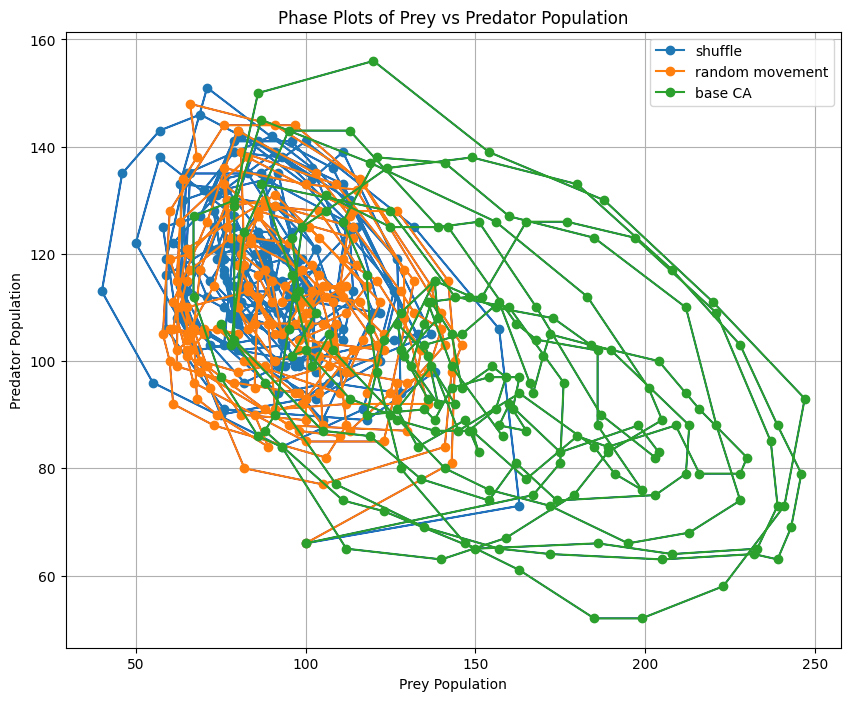

In [ ]:
pathes = ['/content/drive/MyDrive/NaCo_finalProject/experiments/run_shuffle_1.json',
          '/content/drive/MyDrive/NaCo_finalProject/experiments/run_random_1.json',
          '/content/drive/MyDrive/NaCo_finalProject/experiments/run_base_1.json']
phase_plots_from_file_pathes(pathes, pred_birth_rate=0.5, prey_death_rate=1,
                             names=['shuffle', 'random movement', 'base CA'])

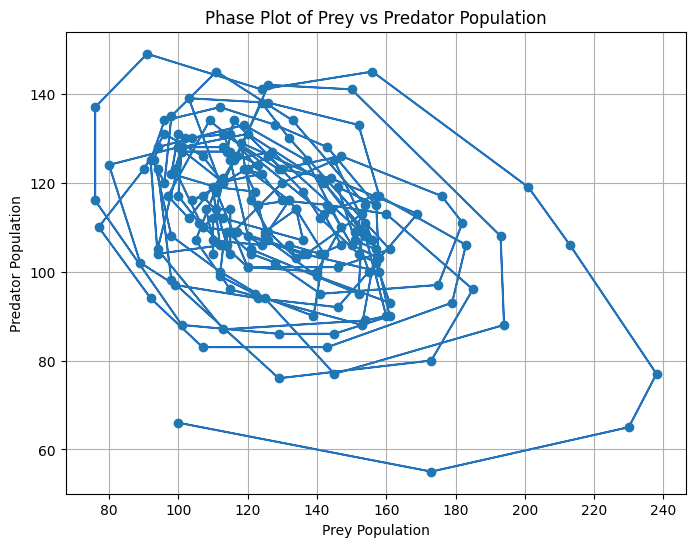

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_shuffle_1.json'
plot_from_params(filepath, 0.5, 0.5, phase_plot=True)

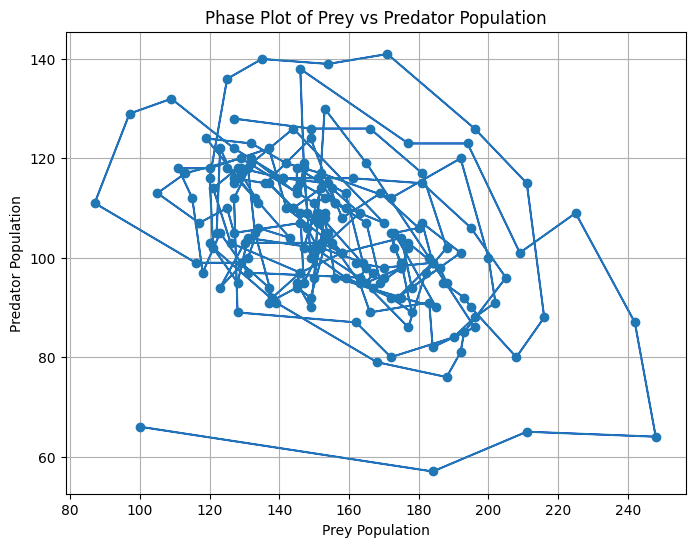

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_random_1.json'
plot_from_params(filepath, 0.5, 0.5, phase_plot=True)

[100, 184, 211, 248, 242, 225, 209, 194, 177, 146, 147, 149, 163, 155, 145, 145, 145, 132, 127, 129, 125, 133, 143, 134, 131, 123, 130, 152, 158, 175, 178, 192, 181, 184, 177, 177, 175, 167, 170, 169, 165, 156, 170, 144, 132, 127, 128, 162, 172, 190, 196, 202, 200, 192, 172, 152, 142, 132, 119, 134, 129, 128, 121, 126, 146, 145, 149, 151, 148, 153, 151, 155, 163, 166, 183, 184, 196, 183, 165, 153, 151, 150, 153, 156, 175, 185, 173, 180, 169, 158, 154, 141, 127, 109, 97, 87, 116, 129, 137, 137, 145, 149, 154, 144, 137, 144, 152, 147, 159, 172, 178, 175, 173, 172, 175, 165, 167, 162, 170, 184, 174, 186, 188, 187, 193, 195, 208, 216, 211, 196, 171, 154, 135, 125, 120, 121, 139, 168, 188, 192, 193, 205, 195, 181, 161, 141, 129, 131, 133, 138, 146, 158, 148, 147, 146, 159, 153, 150, 129, 113, 105, 117, 125, 127, 146, 146, 147, 152, 164, 159, 151, 156, 149, 136, 127, 123, 122, 120, 128, 131, 150, 163, 165, 151, 153, 142, 137, 120, 111, 115, 118, 123, 131, 163, 177, 182, 188, 181, 166, 149, 1

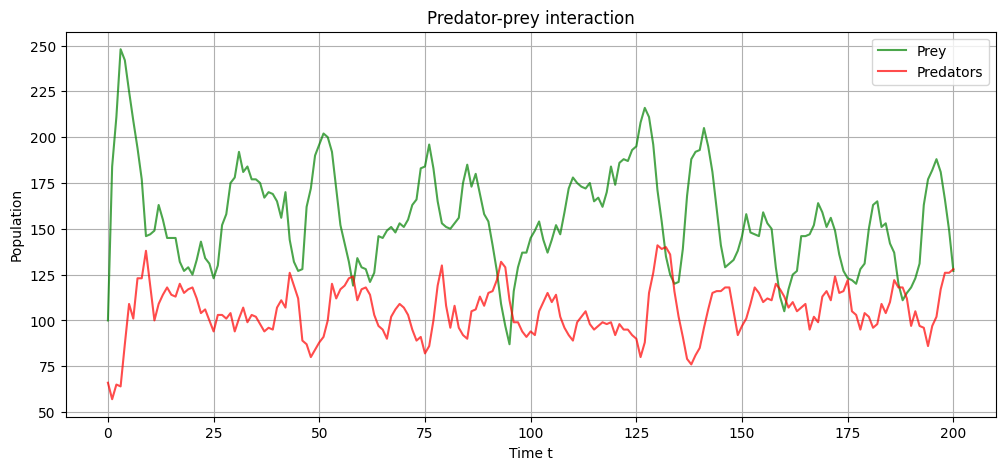

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_random_1.json'
plot_from_params(filepath, 0.5, 0.5)

[100, 173, 230, 238, 213, 201, 156, 124, 91, 76, 76, 101, 129, 145, 161, 156, 145, 130, 116, 107, 117, 137, 153, 156, 141, 118, 121, 126, 134, 132, 141, 147, 142, 109, 97, 103, 110, 112, 115, 115, 108, 110, 124, 120, 136, 158, 157, 144, 150, 158, 169, 144, 130, 116, 114, 101, 94, 113, 154, 160, 154, 127, 115, 121, 152, 153, 142, 120, 101, 100, 106, 120, 140, 147, 137, 119, 104, 94, 93, 98, 112, 125, 145, 194, 193, 150, 126, 117, 113, 111, 114, 114, 121, 128, 141, 175, 182, 176, 147, 129, 113, 115, 116, 111, 120, 146, 161, 154, 132, 124, 113, 107, 96, 90, 77, 92, 107, 143, 179, 183, 158, 152, 126, 103, 112, 124, 119, 122, 111, 104, 107, 113, 136, 134, 132, 125, 126, 140, 161, 157, 152, 141, 136, 126, 113, 100, 80, 89, 99, 123, 146, 155, 151, 154, 133, 111, 98, 96, 94, 98, 129, 173, 185, 160, 143, 130, 115, 102, 100, 98, 111, 105, 115, 153, 157, 151, 146, 157, 143, 128, 112, 96, 92, 94, 113, 112, 122, 139, 142, 134, 125, 123, 132, 120, 123, 113, 101, 99, 107, 110, 110]
[66, 55, 65, 77, 1

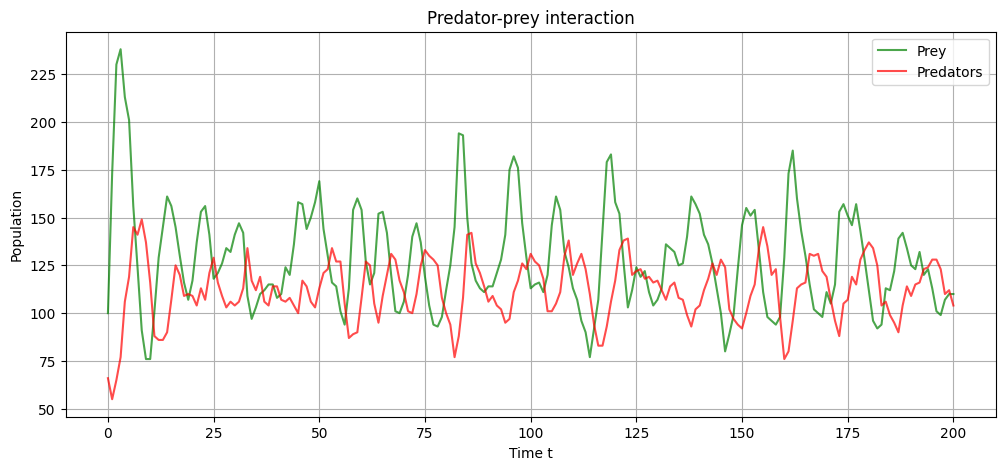

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_shuffle_1.json'
plot_from_params(filepath, 0.5, 0.5)

[6, 5, 4, 3, 2, 2, 4, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[3, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

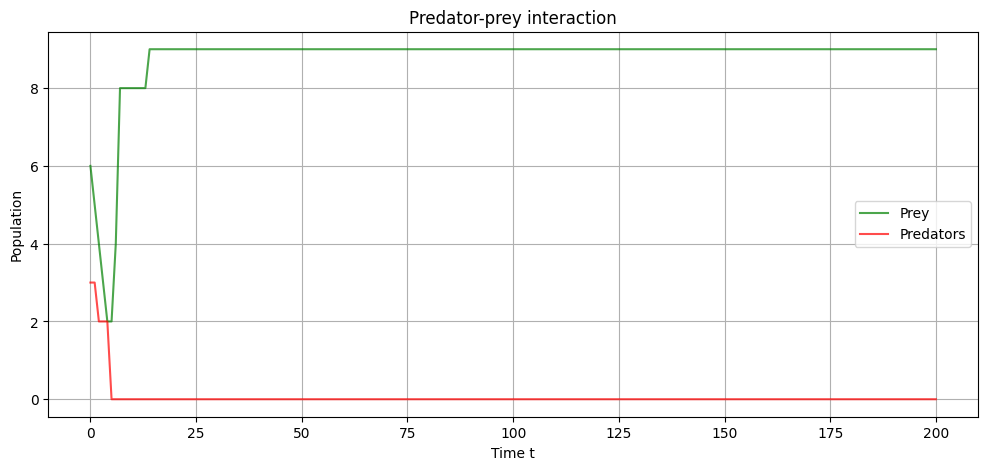

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_shuffle_1_9fieldsize.json'
plot_from_params(filepath, 0.25, 0.25)
# predators are more limited by space as they are drawn to certain region (?)
# higher prey death rate - more chance for predator to survive

In [ ]:
with open(filepath, 'r') as file:
        data = file.read()
    # matrix_prey = {0.0: {0.1}}
json_data = json.loads(data)
for item in json_data:
    if json_data[item]['prey_history'][-1] != 0:
        print(json_data[item])

{'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], 'predator_history': [3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[100, 161, 200, 227, 232, 216, 207, 190, 158, 132, 112, 97, 95, 77, 82, 90, 97, 112, 146, 171, 178, 179, 187, 195, 188, 167, 142, 125, 119, 111, 110, 98, 110, 127, 140, 141, 138, 139, 140, 128, 118, 119, 105, 110, 123, 131, 141, 149, 156, 154, 134, 132, 119, 106, 102, 109, 124, 122, 119, 118, 135, 164, 169, 169, 170, 151, 131, 115, 103, 106, 92, 89, 99, 102, 120, 127, 130, 131, 148, 145, 155, 159, 160, 136, 148, 145, 132, 112, 98, 96, 106, 116, 123, 120, 120, 118, 127, 126, 123, 119, 110, 125, 153, 145, 132, 131, 137, 130, 144, 144, 149, 143, 145, 144, 133, 117, 104, 101, 98, 100, 113, 129, 148, 180, 203, 208, 176, 150, 128, 95, 82, 81, 93, 130, 160, 171, 175, 175, 175, 157, 133, 116, 112, 107, 112, 127, 130, 131, 144, 151, 145, 142, 140, 126, 119, 119, 134, 129, 127, 111, 119, 111, 125, 121, 113, 119, 118, 133, 142, 142, 144, 150, 151, 152, 148, 143, 146, 139, 127, 118, 131, 141, 138, 134, 122, 111, 120, 122, 117, 126, 143, 138, 145, 154, 169, 170, 172, 151, 138, 125, 113]
[66, 72, 65

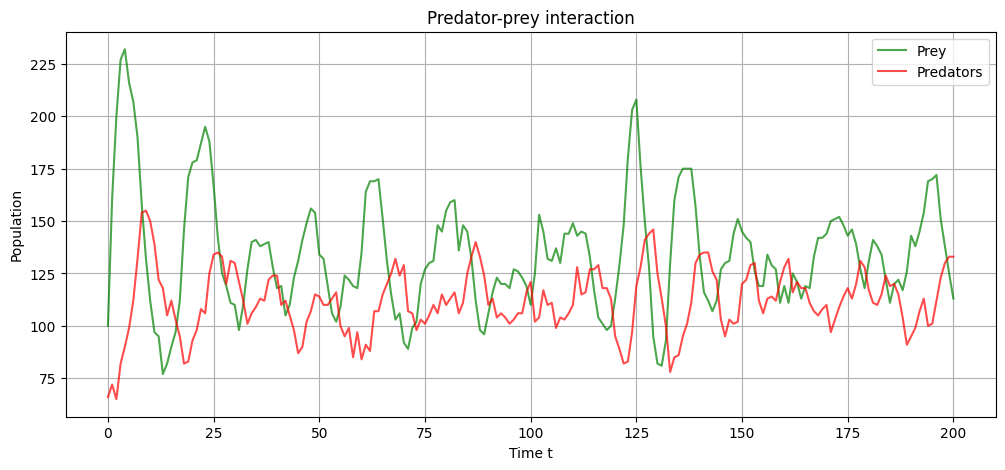

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_hunt_1.json'
plot_from_params(filepath, 0.5, 0.5)

[6.0, 6.131232804641735, 5.980085554088217, 5.4793342318483385, 4.652550370262842, 3.643544017916414, 2.6537231279706543, 1.8322738504731042, 1.2268548749448818, 0.8127291112604489, 0.5405195440624289, 0.36435123301505024, 0.2503304126344623, 0.17583107596787767, 0.12642993729393745, 0.09309335331090464, 0.07017456088429692, 0.05411980004231211, 0.04266618584675059, 0.03435204792429512, 0.028218401780331095, 0.02362590056801982, 0.020141462038088552, 0.01746713980190838, 0.015394899668735435, 0.013777448968541375, 0.012509144688451466, 0.011513335460342415, 0.010733837046927508, 0.010129128152568598, 0.0096683462466362, 0.009328490227803079, 0.009092453524368953, 0.008947625598384294, 0.008884890320706317, 0.008897907781571112, 0.008982599627542272, 0.009136783285373394, 0.009359917571719877, 0.009652930946783905, 0.01001811672910125, 0.010459081920520943, 0.010980741623671377, 0.011589348151964147, 0.012292557959211952, 0.013099532046599667, 0.014021068206388675, 0.015069767351161261,

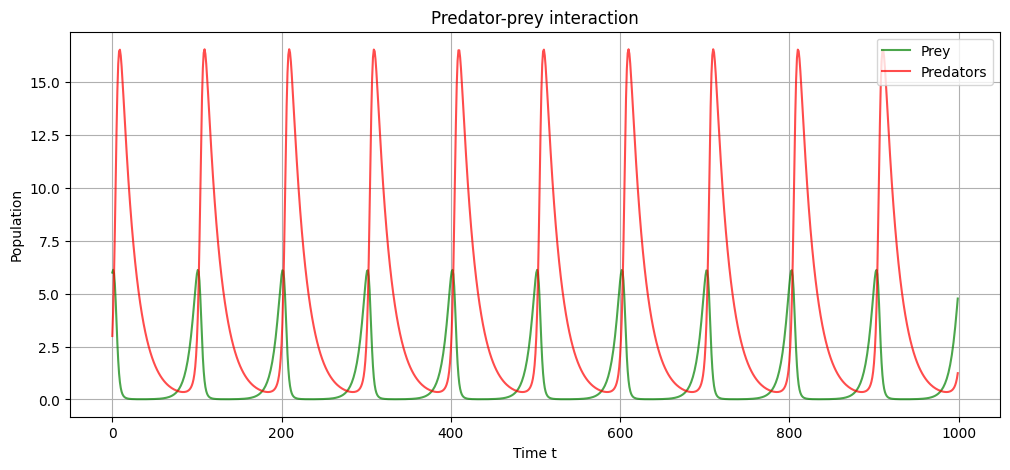

In [ ]:
filepath = '/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_1_9fieldsize.json'
plot_from_params(filepath,1, 1)

# HEATMAPS

In [ ]:
from matplotlib import colors
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

def draw_heatmap(all_stats):
    #a = np.arange(0.2, 1.05, 0.05)
    #b = np.arange(0.2, 1.05, 0.05)
    a = np.arange(0, 1.05, 0.05)
    b = np.arange(0, 1.05, 0.05)
    c = np.array(all_stats['metric'])  # this is the difference between avg peaks of prey and predators. 600 means that the predator dead so there is no peakxs
    c  = c.reshape(21, 21).T[::-1]
    #c = c[:-4, :]
    #c = c[:, 4:]
    norm = TwoSlopeNorm(vmin=c.min(), vcenter=0, vmax=c.max())
    plt.figure(figsize=(8, 6))
    plt.imshow(c, cmap='coolwarm', norm=norm, extent=[min(a), max(a), min(b), max(b)], aspect='auto')
    #plt.imshow(c, cmap=cmap)#, norm=norm)
    plt.colorbar(label='Values')
    plt.ylabel('predator birth rate')   # please check that I didn't swap axises
    plt.xlabel('prey death rate')
    plt.show()

def draw_heatmap_nonorm(all_stats):
    a = np.arange(0, 1.05, 0.05)
    b = np.arange(0, 1.05, 0.05)
    c = np.array(all_stats['metric'])  # this is the difference between avg peaks of prey and predators. 600 means that the predator dead so there is no peakxs
    c  = c.reshape(21, 21).T[::-1]

    plt.figure(figsize=(8, 6))
    plt.imshow(c, cmap='coolwarm', extent=[min(a), max(a), min(b), max(b)], aspect='auto')
    #plt.imshow(c, cmap=cmap)#, norm=norm)
    plt.colorbar(label='Values')
    plt.ylabel('predator birth rate')   # please check that I didn't swap axises
    plt.xlabel('prey death rate')
    plt.show()

def draw_heatmap_lk(all_stats):
    a = np.arange(0.1, 1.05, 0.05)
    b = np.arange(0.1, 1.05, 0.05)
    c = np.array(all_stats['metric'])  # this is the difference between avg peaks of prey and predators. 600 means that the predator dead so there is no peakxs
    c  = c.reshape(21, 21).T[::-1]
    c = c[:-2, :]
    c = c[:, 2:]
    norm = TwoSlopeNorm(vmin=c.min(), vcenter=0, vmax=c.max())
    plt.figure(figsize=(8, 6))
    plt.imshow(c, cmap='coolwarm', norm=norm, extent=[min(a), max(a), min(b), max(b)], aspect='auto')
    #plt.imshow(c, cmap=cmap)#, norm=norm)
    plt.colorbar(label='Values')
    plt.ylabel('predator birth rate')   # please check that I didn't swap axises
    plt.xlabel('prey death rate')
    plt.show()

## Shuffle - assuming baseline

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


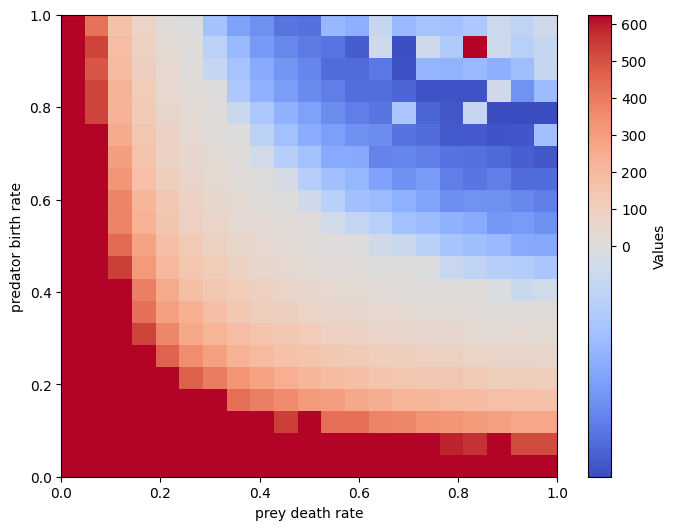

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_shuffle_4.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data)

draw_heatmap(all_stats)

In [ ]:
get_overall_population(json_data)

171
0.0
0.0
[100, 165, 251, 325, 376, 413, 450, 473, 493, 505, 512, 525, 532, 536, 545, 549, 556, 561, 567, 569, 574, 575, 578, 579, 583, 590, 594, 596, 597, 599, 601, 602, 603, 605, 607, 608, 609, 609, 610, 610, 610, 612, 612, 612, 613, 614, 614, 614, 615, 615, 616, 616, 616, 616, 617, 617, 618, 620, 620, 620, 620, 620, 621, 621, 621, 621, 621, 621, 622, 622, 622, 622, 623, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 62

## Base CA

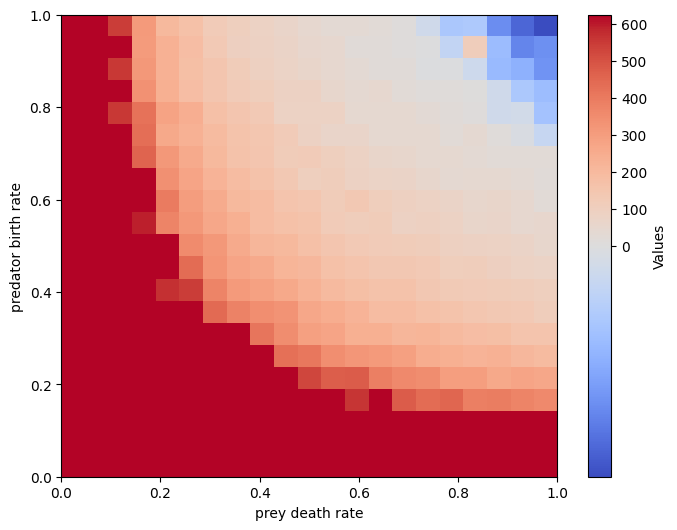

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_base_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data)

draw_heatmap(all_stats)

## Random Movement CA

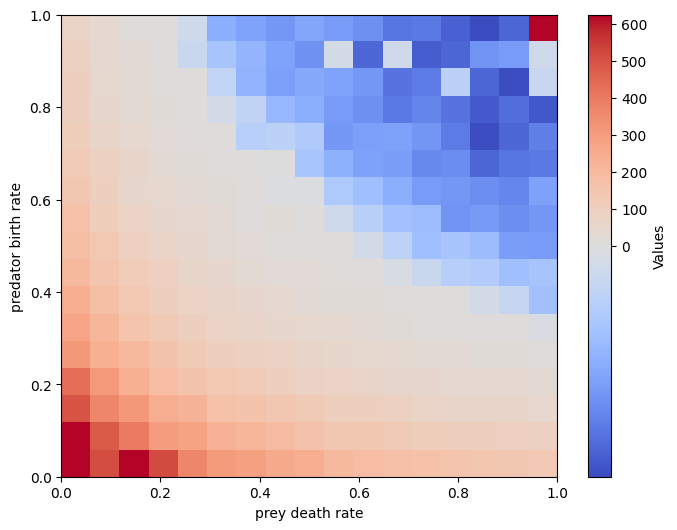

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_random_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data)
#print(np.argmax(all_stats['metric']))
#print(all_stats['metric'][55])
#print(all_stats['prey_peak'][55])
#print(all_stats['predator_peak'][55])

draw_heatmap(all_stats)

## Hunt Movement CA

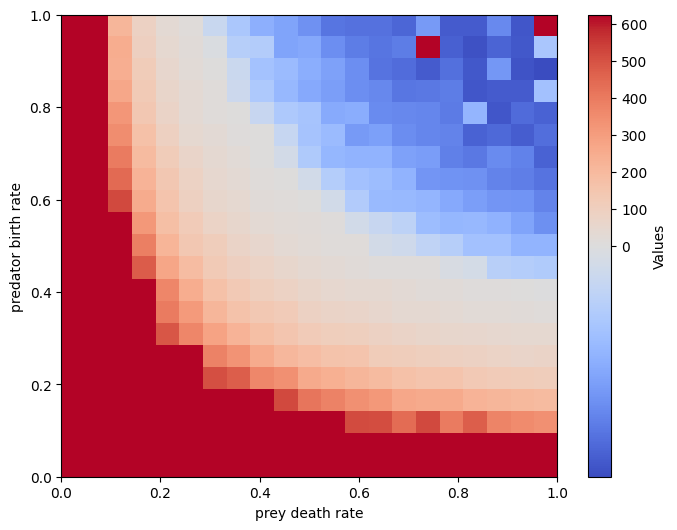

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_hunt_3.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data)

draw_heatmap(all_stats)

## Lotka-Volterra Mean Field

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


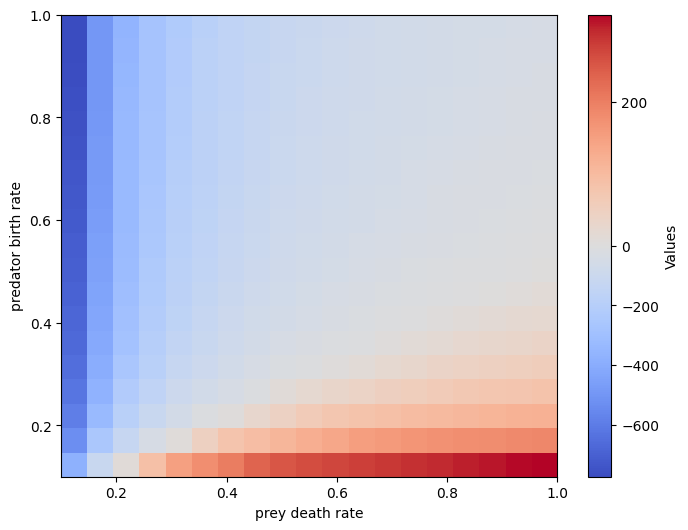

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_matching_meanfield_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

# Decreased Field Size

## Shuffle

{'metric': [8.626865671641792, 8.203980099502488, 8.716417910447761, 8.771144278606966, 8.512437810945274, 8.303482587064677, 8.442786069651742, 8.467661691542288, 8.402985074626866, 8.616915422885572, 8.621890547263682, 8.681592039800996, 8.477611940298507, 8.432835820895521, 8.691542288557214, 8.338308457711443, 8.567164179104477, 8.537313432835822, 8.507462686567164, 8.64676616915423, 8.238805970149254, 8.497512437810945, 8.55223880597015, 8.402985074626866, 8.626865671641792, 8.119402985074627, 8.308457711442786, 8.293532338308458, 8.099502487562189, 8.477611940298507, 8.228855721393035, 8.43781094527363, 8.164179104477611, 8.213930348258707, 8.064676616915422, 8.427860696517412, 8.442786069651742, 8.3681592039801, 8.402985074626866, 8.502487562189055, -0.11940298507462686, -0.13432835820895522, 8.616915422885572, 8.55223880597015, 8.686567164179104, 8.313432835820896, 7.900497512437812, -0.12935323383084577, 8.348258706467663, -0.11442786069651742, 8.318407960199004, 8.25373134328

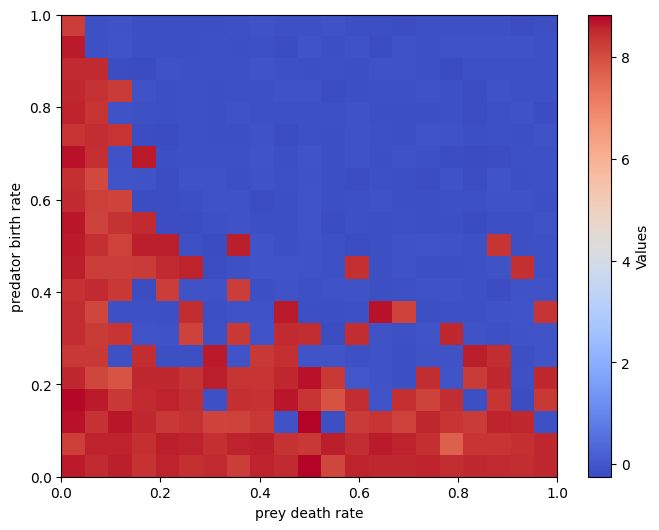

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_base_2_9fieldsize_reverse.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 9)
print(all_stats)

draw_heatmap_nonorm(all_stats)

{'metric': [2.9033069369309237e+59, -9.219605288029204e+260, -1.8153338801353708e+259, -7.466560860159561e+255, -3.2207956214544214e+257, -2.1485401320717453e+277, -1.3266416866497764e+254, -1.711316748074534e+257, -4.742644919259904e+255, 3.034730221391e+291, -1.9666496534569715e+275, -2.7394754233951725e+264, -1.4175059873289473e+252, -1.966708327734391e+275, -1.8544726027518543e+255, -2.2835372229028508e+271, -4.641533825847877e+253, -4.82143260663825e+267, -3.8373818398411067e+248, -5.577795321605808e+260, -8.36416060823776e+272, 2.6712054089883685e+59, -63.875820836751785, -77.77880961117407, -80.99028998721606, -82.81587938412501, -84.17417068956223, -85.13931838590553, -85.39995399513934, -84.04047028871268, -81.06273799280531, -82.47104287951557, -83.90909337567321, -85.32953551073172, -86.70504957649719, -87.9431380549994, -88.8112166095022, -88.71755567322234, -86.14622741119315, -82.66876799821377, -84.0584190297738, -85.42197681235803, 2.4576590061475425e+59, -21.9440064226

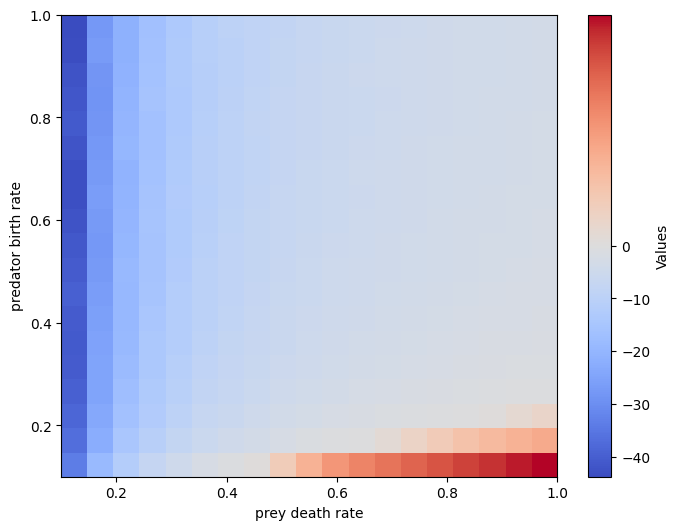

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_1_9fieldsize.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 100000)
print(all_stats)

draw_heatmap_lk(all_stats)

In [ ]:
#print(json_data['441'])
calculate_stats(json_data['441']['prey_history'], json_data['441']['predator_history'])

{'prey_peak': nan,
 'prey_valley': nan,
 'prey_width': 0,
 'prey_avg': 0.9272498111377963,
 'predator_peak': 16.549414507780735,
 'predator_valley': 0.3487670572028747,
 'predator_width': 100.0,
 'predator_avg': 4.205369192211319}

# Increased Field Size

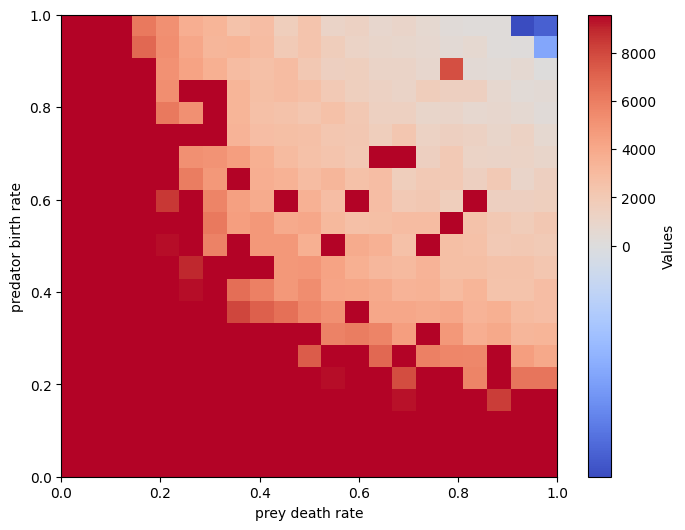

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_base_2_100fieldsize.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 10000)

draw_heatmap(all_stats)

# Sandbox (not used Code)

## Lotka-Volterra Mean Field Fliped

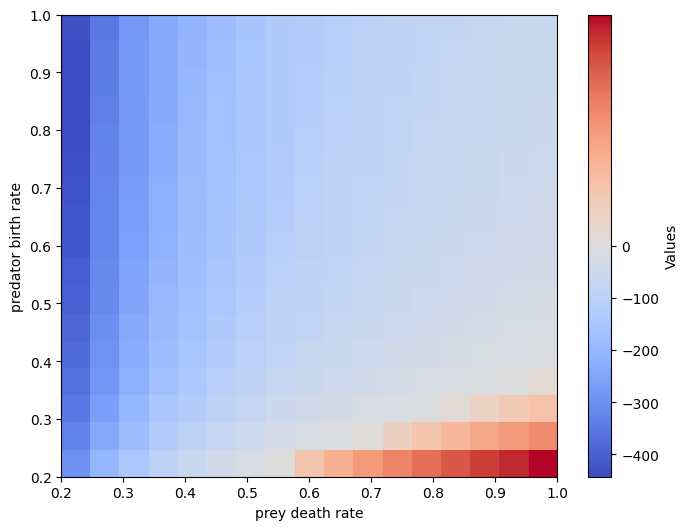

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_matching_meanfield_fliped_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

## Lotka-Volterra no matching

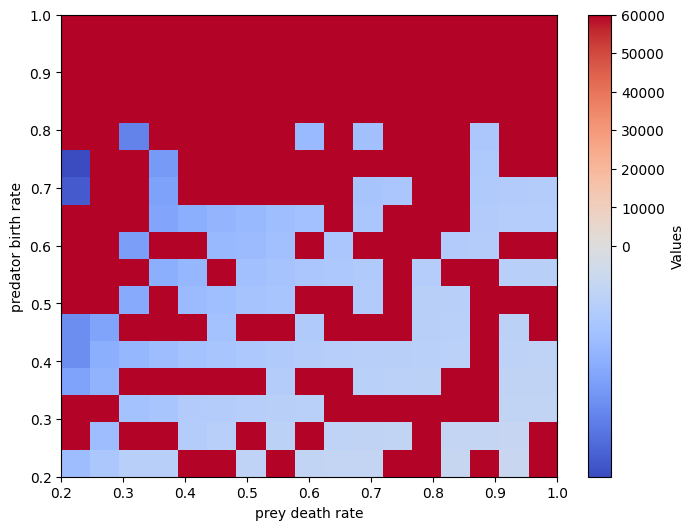

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_nomatching_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

## Lotka-Volterra with Matching

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


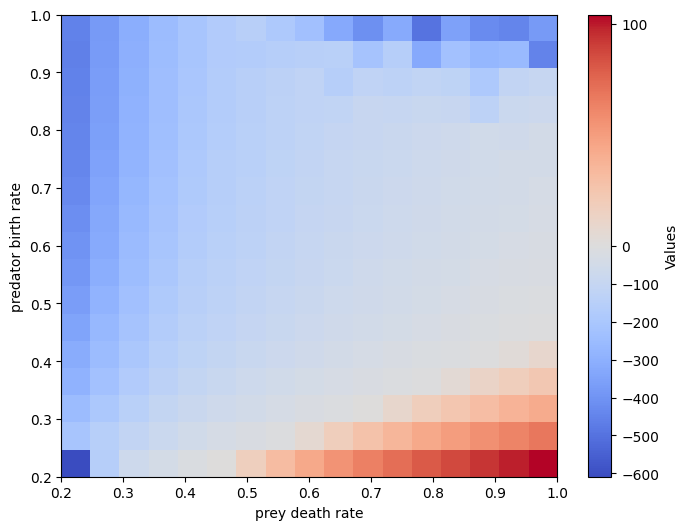

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_matching_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

## Lotka-Volterra Matching 2

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


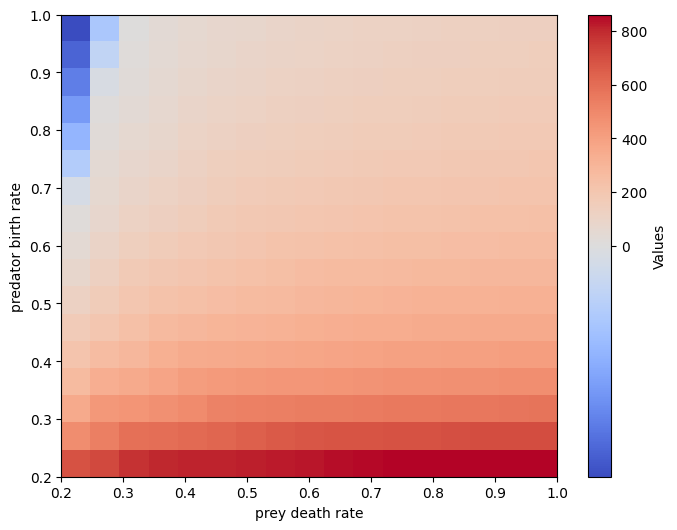

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_matching2_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

## Lotka-Volterra Matching 3

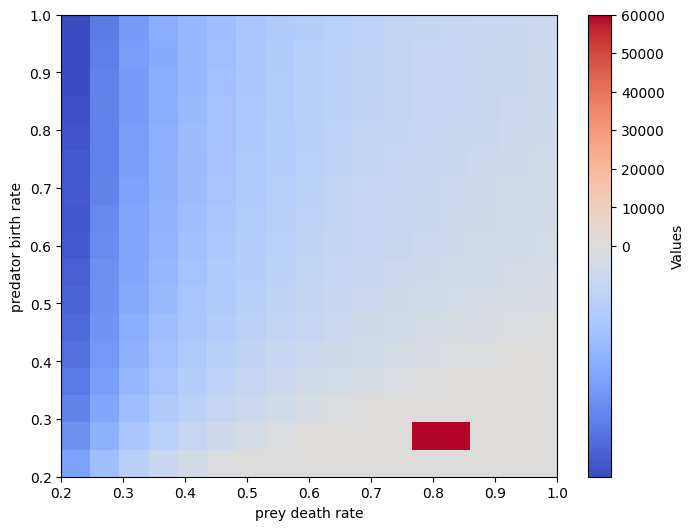

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run_lv_matching3_1.json', 'r') as file:
    data = file.read()

json_data = json.loads(data)
all_stats = get_stats(json_data, 60000)

draw_heatmap_lk(all_stats)

## Check if oscillating or not

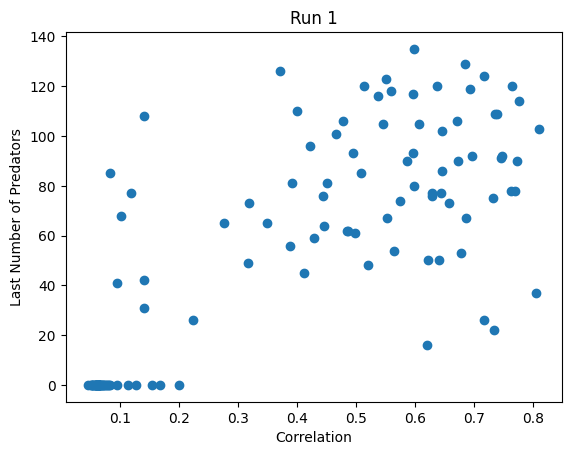

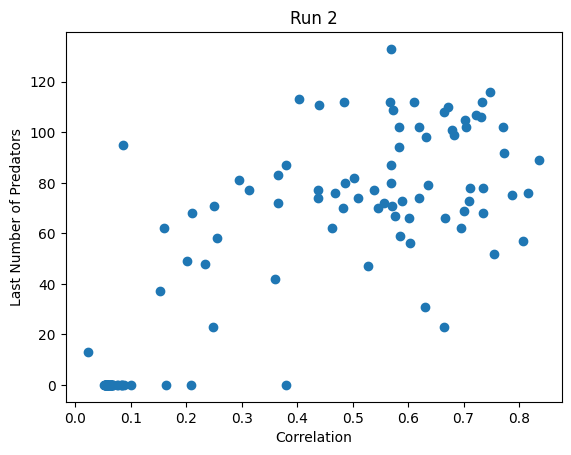

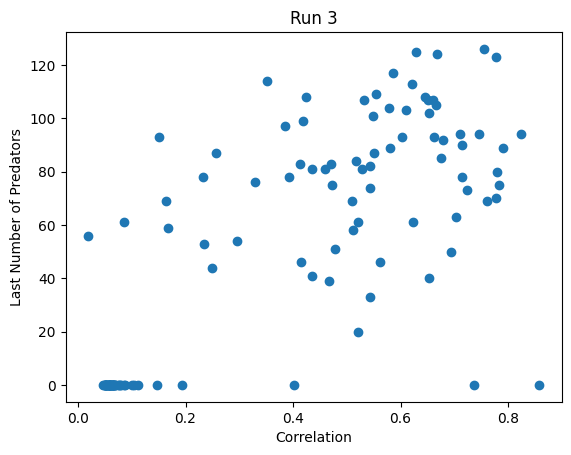

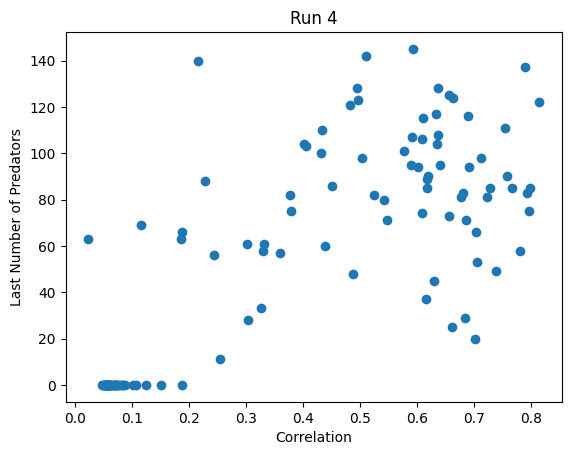

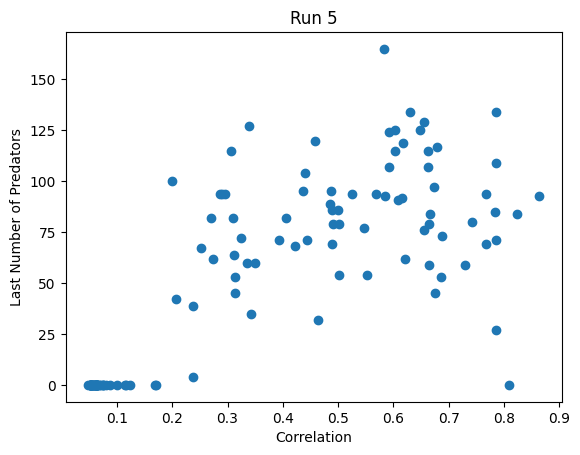

In [ ]:
for i in range(1,6):
    with open(f'/content/drive/MyDrive/NaCo_finalProject/experiments/run{i}.json', 'r') as file:
        data = file.read()

    json_data = json.loads(data)
    correleation = []
    last_predator = []
    for item in json_data:
        correleation.append(abs(json_data[item]['correlation']))
        last_predator.append(json_data[item]['predator_history'][-1])
    plt.xlabel('Correlation')
    plt.ylabel('Last Number of Predators')
    plt.title(f'Run {i}')
    plt.scatter(correleation, last_predator)
    plt.show()

32
3535578
171
0
-0.7279665987070625
(0, -0.7279665987070625)


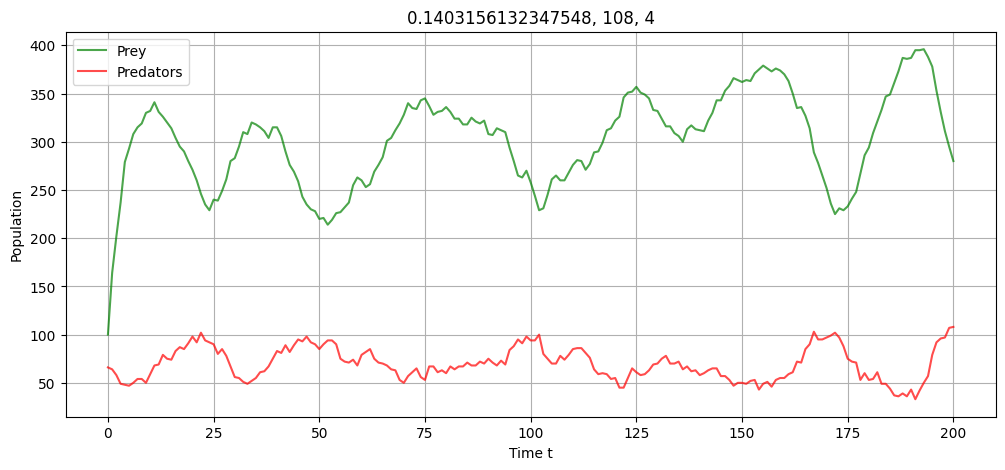

33
3629379
171
0
-0.6858463249984263
(0, -0.6858463249984263)


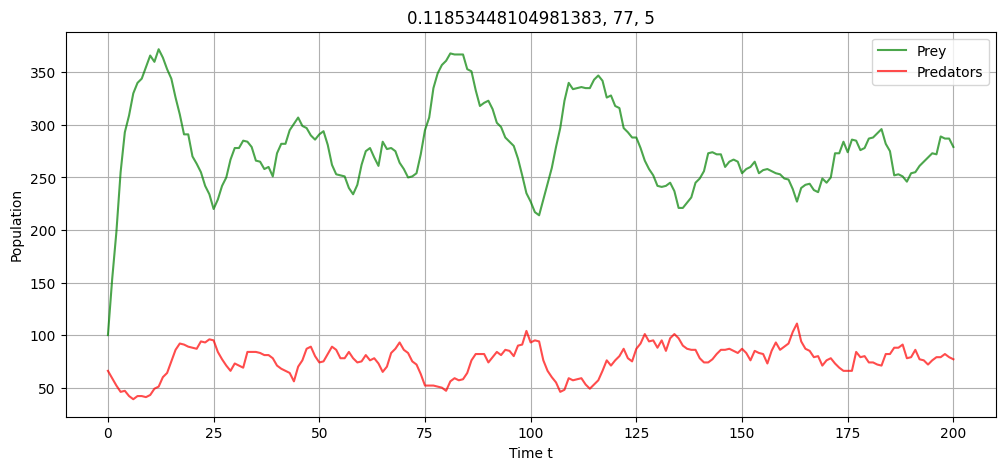

38
3026927
171
-13
-0.1989794911530927
(-13, -0.1989794911530927)


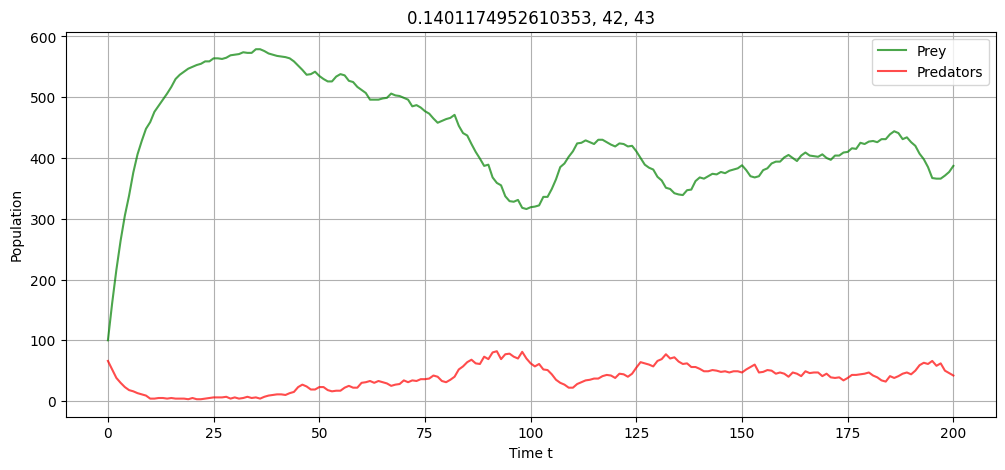

43
3365377
171
0
-0.6318805328436575
(0, -0.6318805328436575)


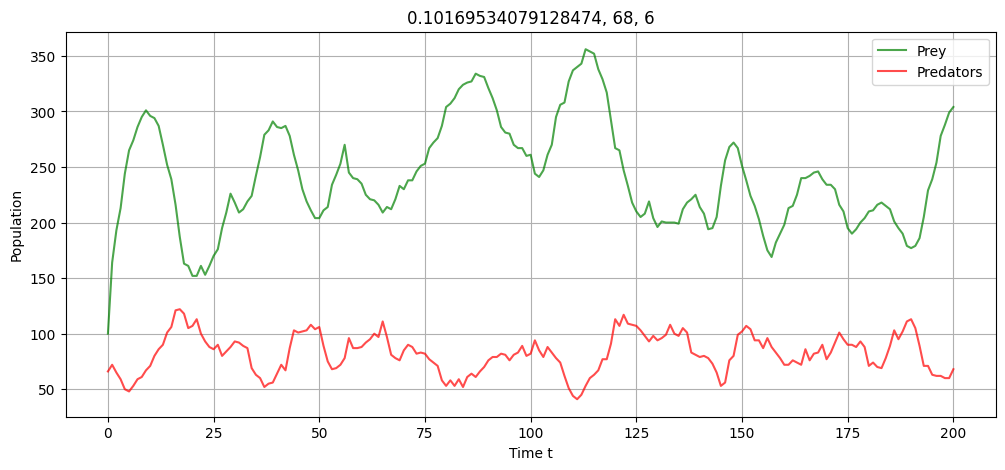

80
3207941
171
0
-0.8215613671346363
(0, -0.8215613671346363)


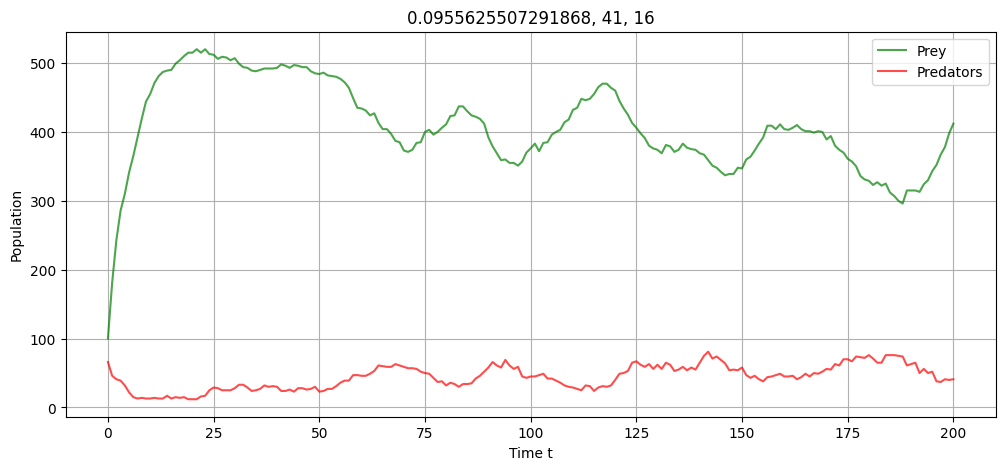

91
3394571
171
0
-0.7928513944739031
(0, -0.7928513944739031)


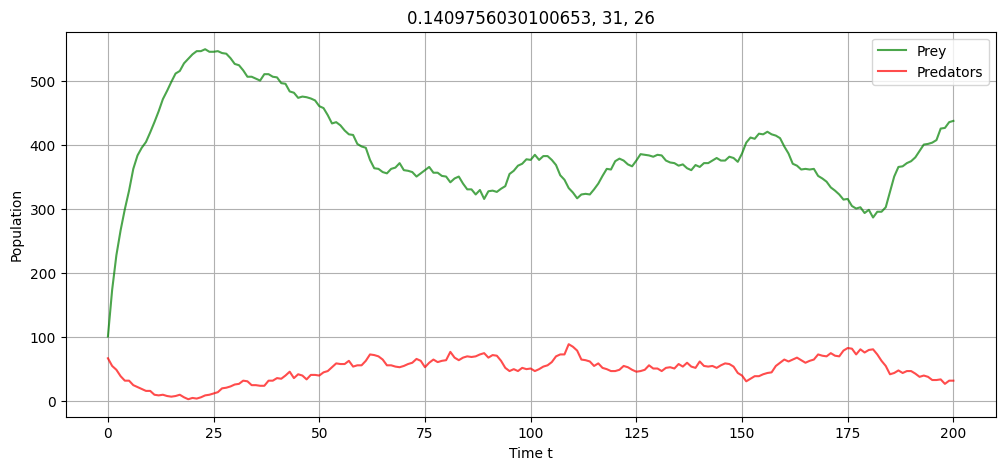

93
3270703
171
0
-0.5494862171416597
(0, -0.5494862171416597)


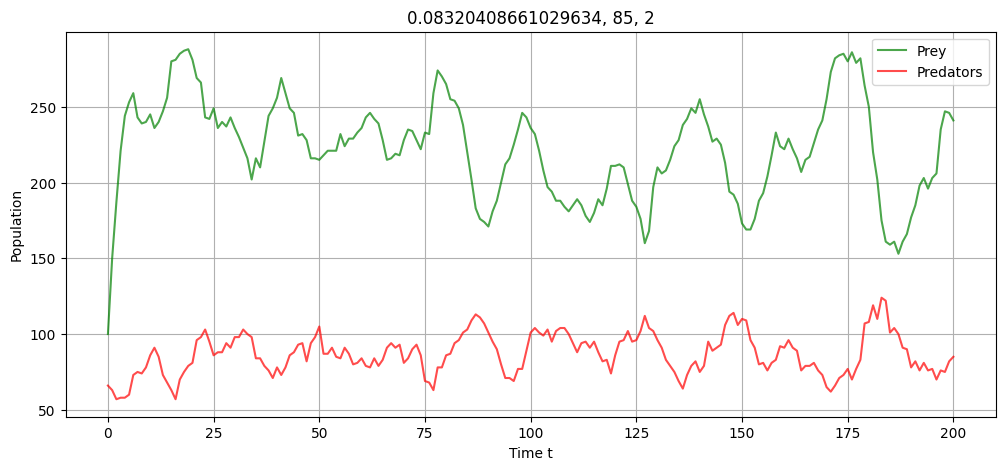

{'1': {'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [100, 185, 259, 316, 369, 397, 421, 451, 471, 487, 506, 514, 524, 529, 537, 543, 546, 552, 556, 561, 562, 564, 567, 571, 576, 580, 583, 585, 588, 588, 591, 595, 595, 595, 596, 598, 600, 601, 601, 603, 603, 603, 605, 606, 609, 611, 613, 615, 615, 615, 615, 615, 615, 616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 619, 619, 620, 620, 620, 620, 621, 621, 621, 621, 622, 622, 623, 623, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625,

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run1.json', 'r') as file:
    data = file.read()

json_data_1 = json.loads(data)

for item in json_data_1:
    c = abs(json_data_1[item]['correlation'])
    p = json_data_1[item]['predator_history'][-1]
    l = abs(json_data_1[item]['lag'])

    if p == 0:
        json_data_1[item]['oscillating'] = False
    elif c > 0.2:
        json_data_1[item]['oscillating'] = True
        #draw_plot(json_data_1[item]['prey_history'], json_data_1[item]['predator_history'], c, l)
    else:
        # these probably have to be decided by hand
        print(item)
        print(cross_correlation_analysis(json_data_1[item]['prey_history'][30:], json_data_1[item]['predator_history'][30:]))
        draw_plot(json_data_1[item]['prey_history'], json_data_1[item]['predator_history'], c, l)
print(json_data_1)

22


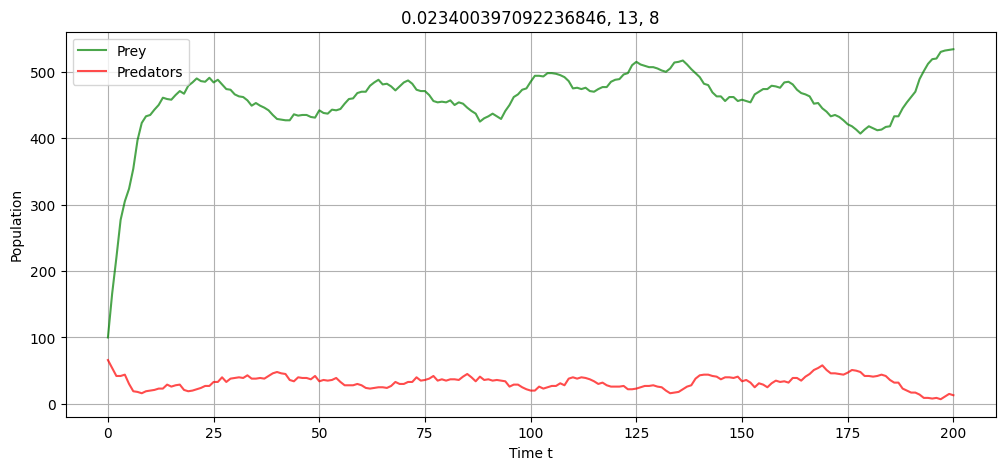

39


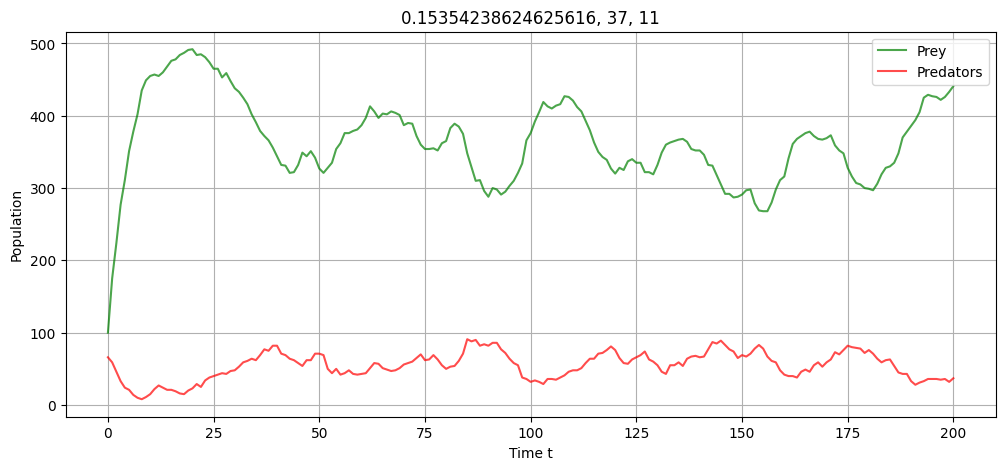

81


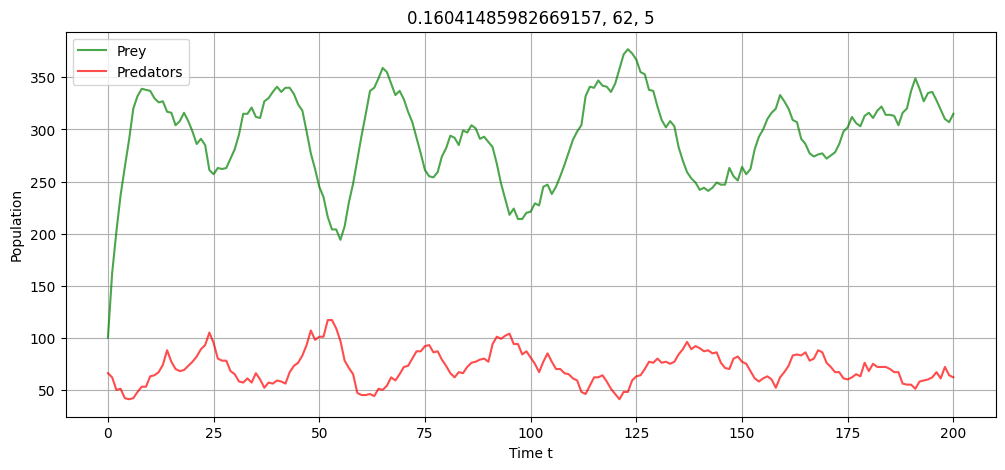

114


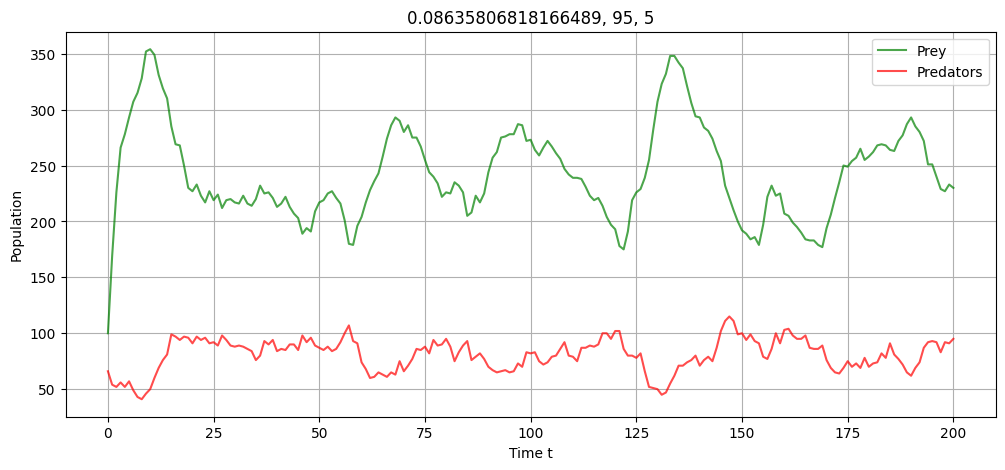

{'1': {'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [100, 184, 258, 295, 337, 373, 400, 432, 455, 475, 487, 505, 524, 533, 539, 544, 545, 556, 557, 564, 571, 578, 583, 587, 590, 593, 596, 597, 600, 602, 603, 605, 607, 608, 608, 609, 609, 609, 609, 610, 612, 614, 614, 614, 614, 614, 615, 615, 616, 617, 617, 617, 619, 619, 619, 619, 619, 621, 622, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625,

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run2.json', 'r') as file:
    data = file.read()

json_data_2 = json.loads(data)

for item in json_data_2:
    c = abs(json_data_2[item]['correlation'])
    p = json_data_2[item]['predator_history'][-1]
    l = abs(json_data_2[item]['lag'])

    if p == 0:
        json_data_2[item]['oscillating'] = False
    elif c > 0.2:
        json_data_2[item]['oscillating'] = True
        #draw_plot(json_data_2[item]['prey_history'], json_data_2[item]['predator_history'], c, l)
    else:
        # these probably have to be decided by hand
        print(item)
        draw_plot(json_data_2[item]['prey_history'], json_data_2[item]['predator_history'], c, l)
print(json_data_2)

29


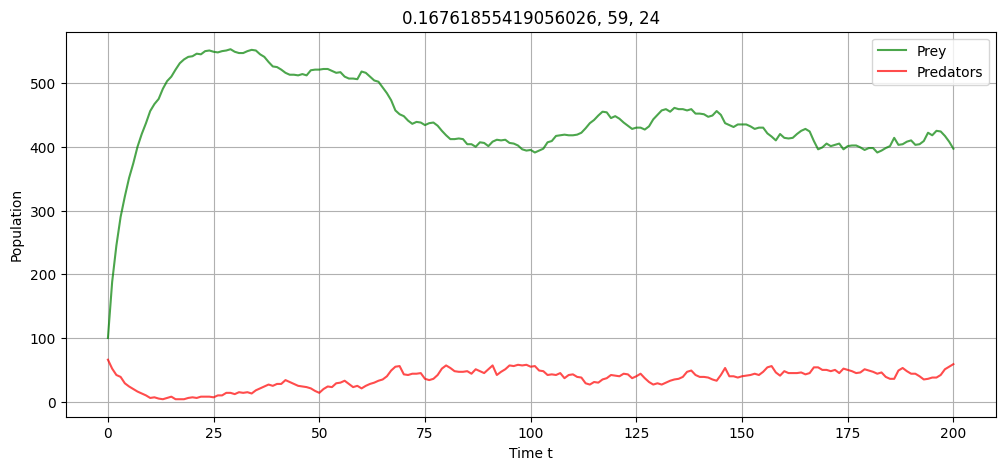

31


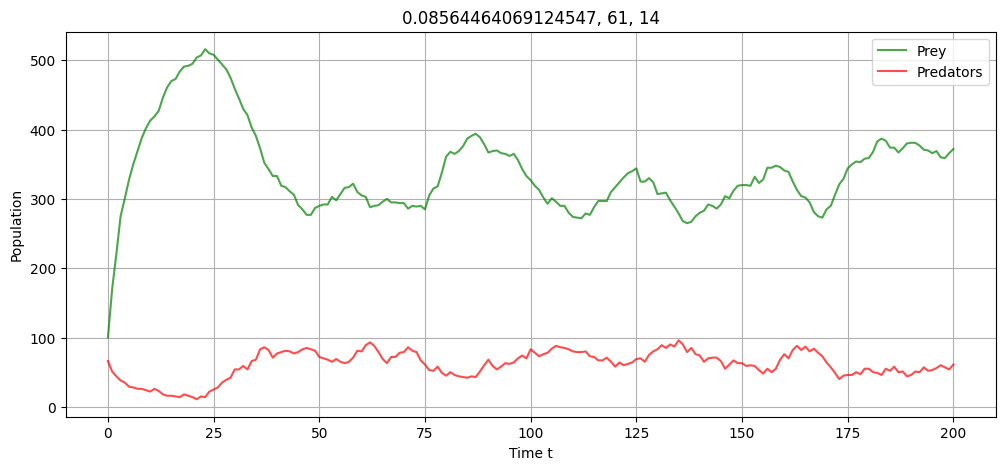

39


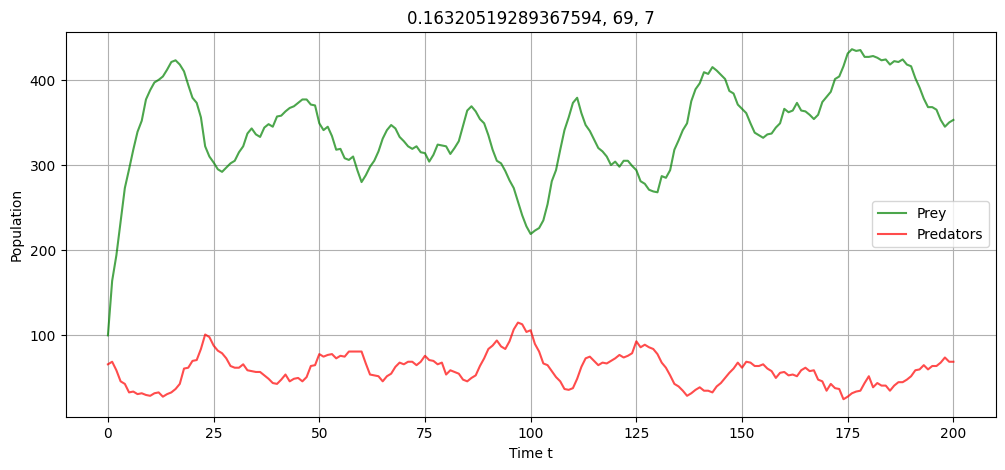

59


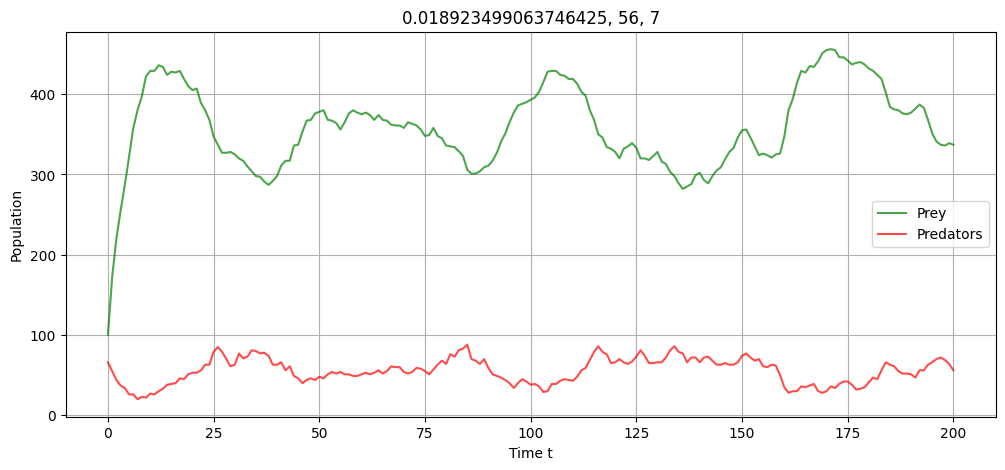

65


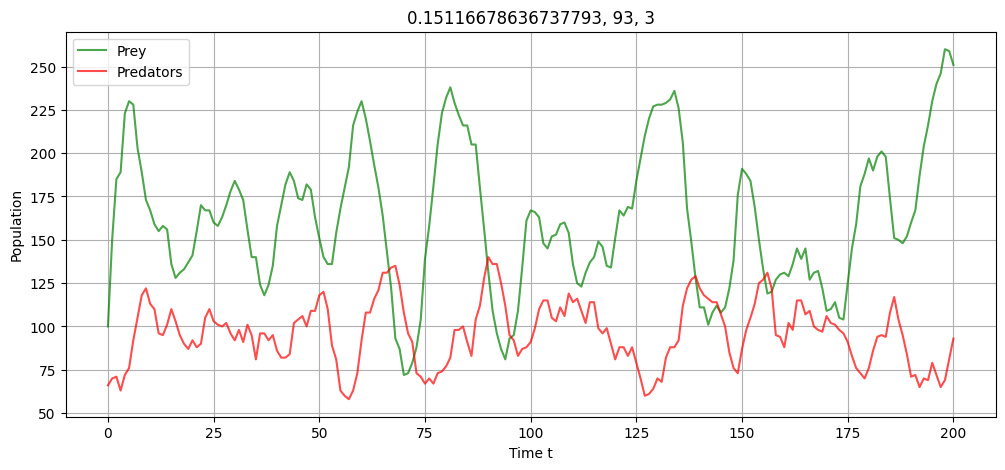

{'1': {'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [100, 192, 248, 303, 335, 375, 407, 432, 454, 471, 488, 498, 513, 522, 531, 535, 546, 551, 553, 559, 567, 573, 576, 582, 583, 587, 592, 595, 598, 599, 601, 603, 605, 606, 606, 606, 607, 608, 610, 610, 610, 611, 613, 614, 614, 614, 614, 614, 614, 615, 615, 616, 616, 617, 617, 618, 618, 618, 619, 619, 619, 619, 620, 620, 620, 620, 620, 621, 621, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625,

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run3.json', 'r') as file:
    data = file.read()

json_data_3 = json.loads(data)

for item in json_data_3:
    c = abs(json_data_3[item]['correlation'])
    p = json_data_3[item]['predator_history'][-1]
    l = abs(json_data_3[item]['lag'])

    if p == 0:
        json_data_3[item]['oscillating'] = False
    elif c > 0.2:
        json_data_3[item]['oscillating'] = True
        #draw_plot(json_data_3[item]['prey_history'], json_data_3[item]['predator_history'], c, l)
    else:
        # these probably have to be decided by hand
        print(item)
        draw_plot(json_data_3[item]['prey_history'], json_data_3[item]['predator_history'], c, l)
print(json_data_3)

33


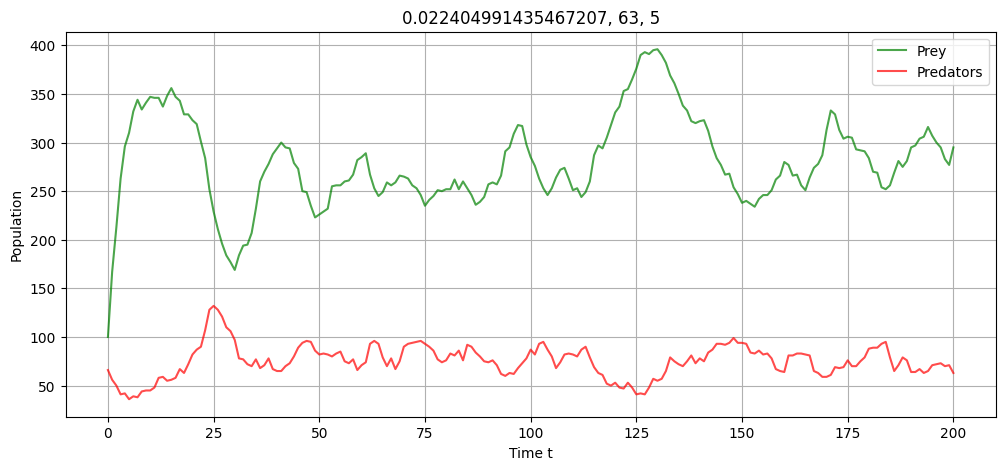

39


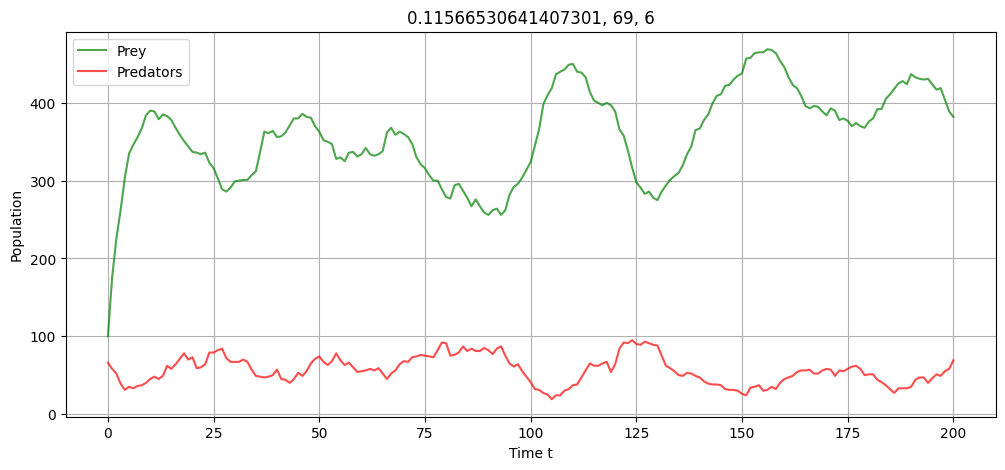

71


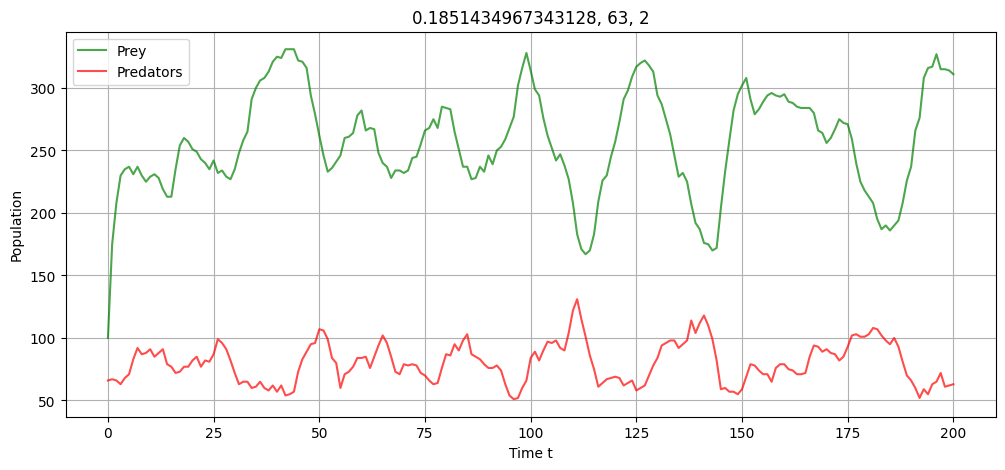

92


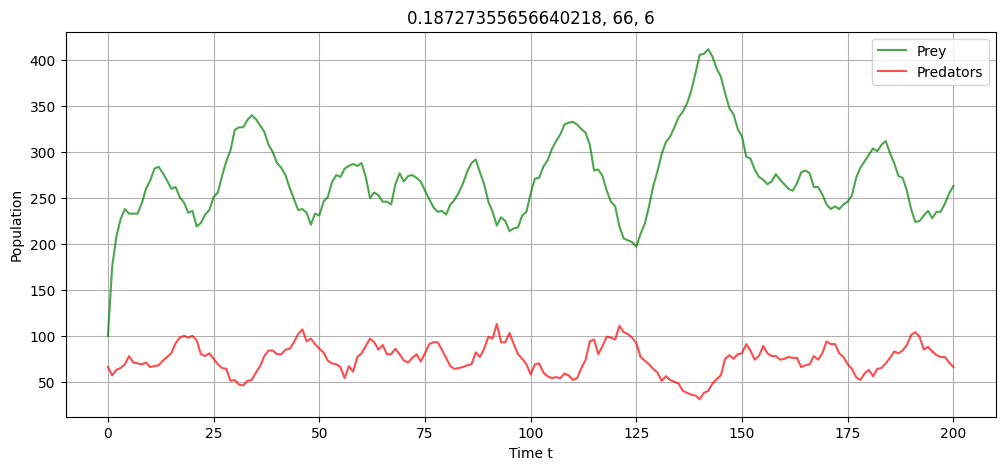

{'1': {'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [100, 175, 237, 288, 333, 383, 410, 433, 449, 465, 481, 500, 517, 530, 537, 546, 554, 561, 567, 569, 570, 572, 576, 579, 582, 583, 585, 585, 587, 587, 588, 589, 591, 592, 592, 593, 593, 594, 598, 601, 602, 603, 603, 604, 605, 606, 609, 609, 610, 610, 611, 613, 613, 614, 615, 615, 616, 617, 618, 619, 619, 620, 620, 620, 620, 620, 620, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 622, 622, 622, 622, 622, 622, 623, 623, 623, 623, 623, 623, 623, 623, 624, 624, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625,

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run4.json', 'r') as file:
    data = file.read()

json_data_4 = json.loads(data)

for item in json_data_4:
    c = abs(json_data_4[item]['correlation'])
    p = json_data_4[item]['predator_history'][-1]
    l = abs(json_data_4[item]['lag'])

    if p == 0:
        json_data_4[item]['oscillating'] = False
    elif c > 0.2:
        json_data_4[item]['oscillating'] = True
        #draw_plot(json_data_4[item]['prey_history'], json_data_4[item]['predator_history'], c, l)
    else:
        # these probably have to be decided by hand
        print(item)
        draw_plot(json_data_4[item]['prey_history'], json_data_4[item]['predator_history'], c, l)
print(json_data_4)

40


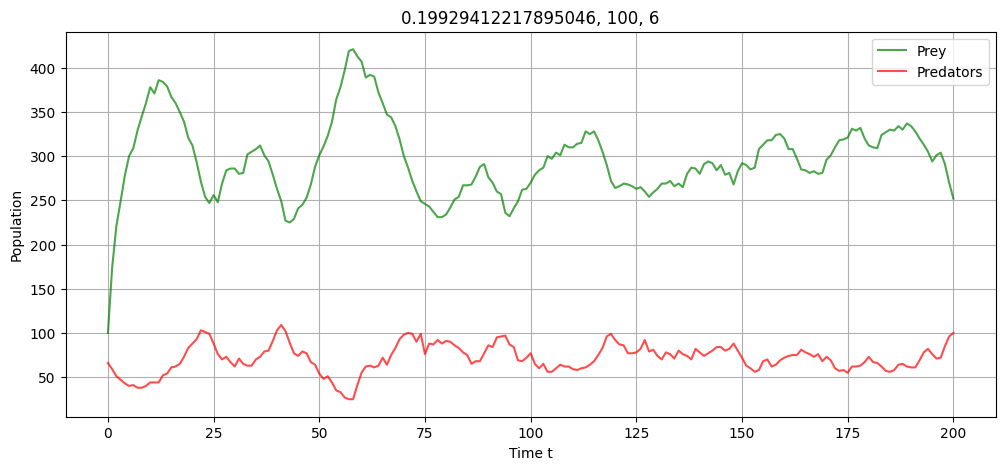

{'1': {'prey_death_rate': 0.0, 'predator_birth_rate': 0.0, 'prey_history': [100, 187, 248, 300, 353, 376, 405, 420, 442, 461, 477, 494, 503, 513, 520, 528, 528, 535, 543, 552, 559, 564, 570, 572, 574, 578, 579, 579, 581, 582, 586, 586, 593, 595, 596, 599, 602, 604, 605, 605, 606, 606, 607, 608, 608, 609, 609, 609, 610, 611, 611, 612, 612, 612, 613, 615, 617, 619, 619, 619, 620, 620, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625, 625,

In [ ]:
with open('/content/drive/MyDrive/NaCo_finalProject/experiments/run5.json', 'r') as file:
    data = file.read()

json_data_5 = json.loads(data)

for item in json_data_5:
    c = abs(json_data_5[item]['correlation'])
    p = json_data_5[item]['predator_history'][-1]
    l = abs(json_data_5[item]['lag'])

    if p == 0:
        json_data_5[item]['oscillating'] = False
    elif c > 0.2:
        json_data_5[item]['oscillating'] = True
        #draw_plot(json_data_5[item]['prey_history'], json_data_5[item]['predator_history'], c, l)
    else:
        # these probably have to be decided by hand
        print(item)
        draw_plot(json_data_5[item]['prey_history'], json_data_5[item]['predator_history'], c, l)
print(json_data_5)

## Draw Parameter Space

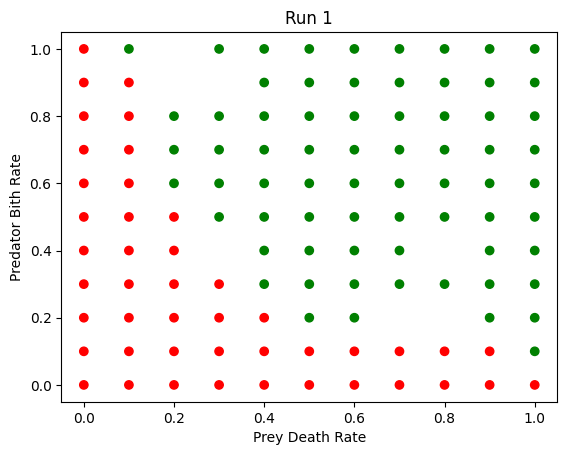

In [ ]:
prey_death_rate_1 = []
predator_birth_rate_1 = []
label_1 = []
for item in json_data_1:
    if 'oscillating' in json_data_1[item]:
        prey_death_rate_1.append(json_data_1[item]['prey_death_rate'])
        predator_birth_rate_1.append(json_data_1[item]['predator_birth_rate'])
        label_1.append(json_data_1[item]['oscillating'])

colors = ['green' if label else 'red' for label in label_1]
plt.scatter(prey_death_rate_1, predator_birth_rate_1, c=colors)

# Step 5: Add Labels and Title
plt.xlabel('Prey Death Rate')
plt.ylabel('Predator Bith Rate')
plt.title('Run 1')

# Step 6: Show the Plot
plt.show()

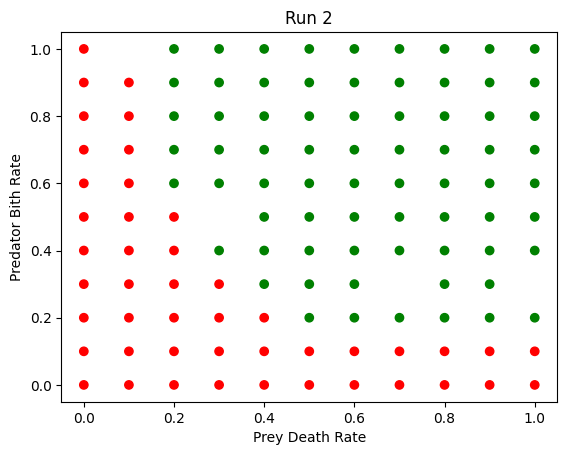

In [ ]:
prey_death_rate_2 = []
predator_birth_rate_2 = []
label_2 = []
for item in json_data_2:
    if 'oscillating' in json_data_2[item]:
        prey_death_rate_2.append(json_data_2[item]['prey_death_rate'])
        predator_birth_rate_2.append(json_data_2[item]['predator_birth_rate'])
        label_2.append(json_data_2[item]['oscillating'])

colors = ['green' if label else 'red' for label in label_2]
plt.scatter(prey_death_rate_2, predator_birth_rate_2, c=colors)

# Step 5: Add Labels and Title
plt.xlabel('Prey Death Rate')
plt.ylabel('Predator Bith Rate')
plt.title('Run 2')

# Step 6: Show the Plot
plt.show()

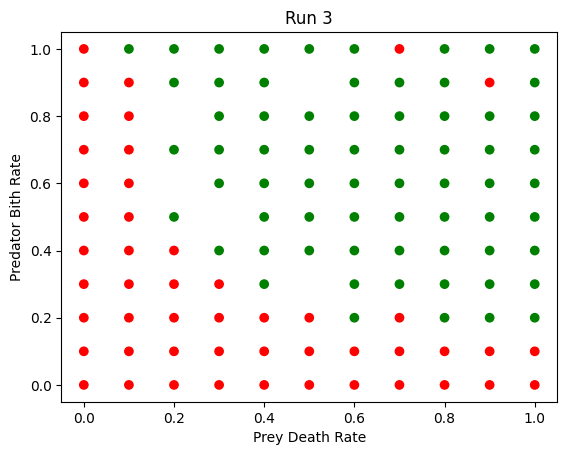

In [ ]:
prey_death_rate_3 = []
predator_birth_rate_3 = []
label_3 = []
for item in json_data_3:
    if 'oscillating' in json_data_3[item]:
        prey_death_rate_3.append(json_data_3[item]['prey_death_rate'])
        predator_birth_rate_3.append(json_data_3[item]['predator_birth_rate'])
        label_3.append(json_data_3[item]['oscillating'])

colors = ['green' if label else 'red' for label in label_3]
plt.scatter(prey_death_rate_3, predator_birth_rate_3, c=colors)

# Step 5: Add Labels and Title
plt.xlabel('Prey Death Rate')
plt.ylabel('Predator Bith Rate')
plt.title('Run 3')

# Step 6: Show the Plot
plt.show()

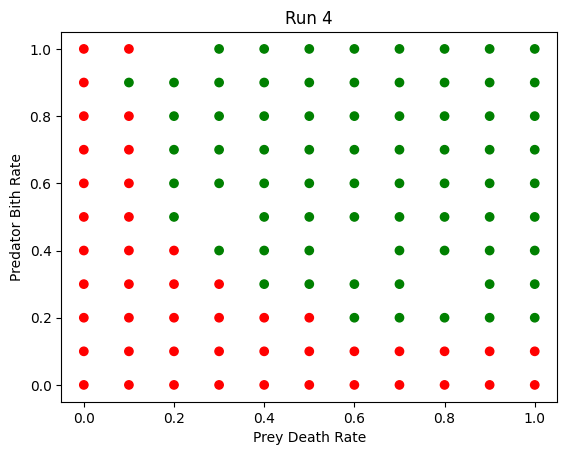

In [ ]:
prey_death_rate_4 = []
predator_birth_rate_4 = []
label_4 = []
for item in json_data_4:
    if 'oscillating' in json_data_4[item]:
        prey_death_rate_4.append(json_data_4[item]['prey_death_rate'])
        predator_birth_rate_4.append(json_data_4[item]['predator_birth_rate'])
        label_4.append(json_data_4[item]['oscillating'])

colors = ['green' if label else 'red' for label in label_4]
plt.scatter(prey_death_rate_4, predator_birth_rate_4, c=colors)

# Step 5: Add Labels and Title
plt.xlabel('Prey Death Rate')
plt.ylabel('Predator Bith Rate')
plt.title('Run 4')

# Step 6: Show the Plot
plt.show()

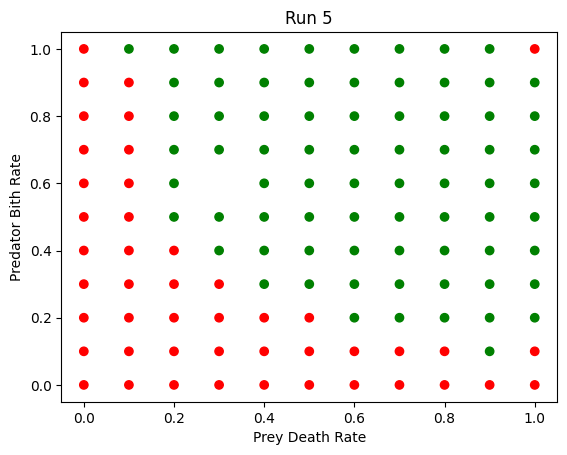

In [ ]:
prey_death_rate_5 = []
predator_birth_rate_5 = []
label_5 = []
for item in json_data_5:
    if 'oscillating' in json_data_5[item]:
        prey_death_rate_5.append(json_data_5[item]['prey_death_rate'])
        predator_birth_rate_5.append(json_data_5[item]['predator_birth_rate'])
        label_5.append(json_data_5[item]['oscillating'])

colors = ['green' if label else 'red' for label in label_5]
plt.scatter(prey_death_rate_5, predator_birth_rate_5, c=colors)

# Step 5: Add Labels and Title
plt.xlabel('Prey Death Rate')
plt.ylabel('Predator Bith Rate')
plt.title('Run 5')

# Step 6: Show the Plot
plt.show()